In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [8]:
# Split features & group variables
G = X[["store_id", "store_primary_category"]]
# X = X.drop(["store_id", "store_primary_category"], axis = 1) Keep the group variables as fixed effects to model interactions between them & other variables

In [9]:
# Enforce dtype of group variables
G["store_id"] = G["store_id"].astype("str") 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
# Nest store_id into store category
G_nested = gpb.get_nested_categories(G["store_primary_category"], G["store_id"])
G = np.column_stack((G["store_primary_category"], G_nested))

In [11]:
G

array([['dessert', 3173],
       ['cafe', 2397],
       ['smoothie', 8938],
       ['mexican', 6352],
       ['cafe', 2263],
       ['american', 219],
       ['sandwich', 8402],
       ...,
       ['mexican', 6142],
       ['pizza', 7940],
       ['italian', 4729],
       ['pizza', 7598],
       ['italian', 5048],
       ['american', 765],
       ['american', 170]], dtype=object)

In [12]:
train_end = int(len(df) * 0.6)

In [13]:
val_end = train_end + int(len(df) * 0.2)

In [14]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
G_train, G_val, G_test = G[:train_end], G[train_end:val_end], G[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [15]:
# Create target encoders

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder)
])

In [16]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# Hyperparameter tuning

In [20]:
# Objective function
def objective_gpb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    #max_depth = trial.suggest_int("max_depth", 2, 20) # Max depth of 20 is too restrictive for LightGBM
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_float("min_child_weight", 0.001, 20, log = True)
    reg_alpha = trial.suggest_float("l1_reg", 0, 1)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Create model
    #callbacks = [gpb.early_stopping(50)]
    
    model = gpb.GPBoostRegressor(
        n_jobs = 10,
        #device_type = "gpu",
        n_estimators = 5000,
        num_leaves = num_leaves,
        random_state = random_state,
        #max_depth = max_depth,
        max_depth = -1,
        min_child_samples = min_child_samples,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        colsample_bytree = colsample_bytree
    )

    # Create random effects model
    gp_model = gpb.GPModel(
        group_data = G_train, # Random intercepts for each group
        likelihood = "gaussian",
        seed = random_state
    )
    gp_model.set_prediction_data(group_data_pred = G_val)

    # Train model with early stopping
    model.fit(
        X_train, 
        y_train,
        gp_model = gp_model, 
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 50,
        #callbacks = callbacks,
        verbose = False)

    # Report best number of rounds
    trial.set_user_attr("n_rounds", (model.best_iteration_ + 1))
    
    return model.best_score_['valid_0']['l2']


In [21]:
# Create study
study_gpb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_gpb",
  direction = "minimize"
)

In [22]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_gpb.optimize(
  objective_gpb, 
  n_trials = 1000,
  show_progress_bar = True)

Best trial: 339. Best value: 892278:  43%|██████████████████                        | 431/1000 [24:56<32:55,  3.47s/it]


[W 2023-11-27 18:12:47,482] Trial 431 failed with parameters: {'learning_rate': 0.4702523685104163, 'num_leaves': 286, 'min_child_samples': 166, 'min_child_weight': 0.303824677610985, 'l1_reg': 0.4503760167853367, 'l2_reg': 0.0033460777905171477, 'colsample_bytree': 0.9166617232266498} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_70568\765108318.py", line 42, in objective_gpb
    model.fit(
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\gpboost\sklearn.py", line 841, in fit
    super().fit(X, y,
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\gpboost\sklear

KeyboardInterrupt: 

In [23]:
# Save tuning log
trials_gpb = study_gpb.trials_dataframe().sort_values("value", ascending = True)
trials_gpb.to_csv("./ModifiedData/trials_gpb3.csv", index = False)

# Testing & diagnostics

In [24]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_gpb3.csv").iloc[0]

In [25]:
best_tune

number                                             339
value                                      892278.2600
datetime_start              2023-11-27 18:07:15.174296
datetime_complete           2023-11-27 18:07:18.966196
duration                        0 days 00:00:03.791900
params_colsample_bytree                         0.9826
params_l1_reg                                   0.0001
params_l2_reg                                   0.1338
params_learning_rate                            0.4838
params_min_child_samples                           201
params_min_child_weight                         0.0038
params_num_leaves                                  219
user_attrs_n_rounds                            45.0000
state                                         COMPLETE
Name: 0, dtype: object

In [26]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
G_train, G_test = G[:val_end], G[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [27]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [28]:
# Create gpb data
train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [29]:
# Create random effects model
gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

In [30]:
# Create params dict
params = {
    "random_state": random_state,
    "n_estimators": int(best_tune["user_attrs_n_rounds"]),
    "num_leaves": best_tune["params_num_leaves"],
    "min_child_samples": best_tune["params_min_child_samples"],
    "learning_rate": best_tune["params_learning_rate"],
    "min_child_weight": best_tune["params_min_child_weight"],
    "reg_alpha": best_tune["params_l1_reg"],
    "reg_lambda": best_tune["params_l2_reg"],
    "colsample_bytree": best_tune["params_colsample_bytree"]
}

In [31]:
# Train booster
model = gpb.train(
    params = params,
    train_set = train,
    gp_model = gp_model
)

Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 3127
[GPBoost] [Info] Number of data points in the train set: 88345, number of used features: 29
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=2816.359805
[GPBoost] [Info] Start training from score 2816.359805


In [32]:
# Make predictions on test data
preds = model.predict(X_test, group_data_pred = G_test, predict_var = True, pred_latent = True)

In [33]:
preds

{'fixed_effect': array([2816.3805, 2816.3606, 2816.3803, 2816.3715, 2816.3909, 2816.3669,
        2816.368 , ..., 2816.3456, 2816.3414, 2816.3365, 2816.337 ,
        2816.3532, 2816.3513, 2816.3561]),
 'random_effect_mean': array([-110.3936,  278.697 , -131.8946,  285.3557,  124.2521,  235.1495,
        -104.4892, ..., -295.417 ,  224.3178, -504.2085, -110.1404,
         634.0625,  694.9236, -110.3936]),
 'random_effect_cov': array([ 2562.2169, 27428.3234, 31186.6012, 18621.0777, 25912.4452,
        44563.661 ,  3818.0559, ..., 37383.0517, 32192.309 , 16618.2061,
        42531.0936, 94755.6759, 78546.9416,  2562.2169]),
 'response_mean': None,
 'response_var': None}

In [34]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["fixed"] = preds['fixed_effect']
df_pred["random"] = preds["random_effect_mean"]
df_pred["random_sd"] = np.sqrt(preds["random_effect_cov"])
df_pred["preds"] = df_pred["fixed"] + df_pred["random"]
df_pred["actual"] = y_test
df_pred["residual"] = y_test - df_pred["preds"]

In [35]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
1070.9949306061976
MAPE:
0.27814039853870315


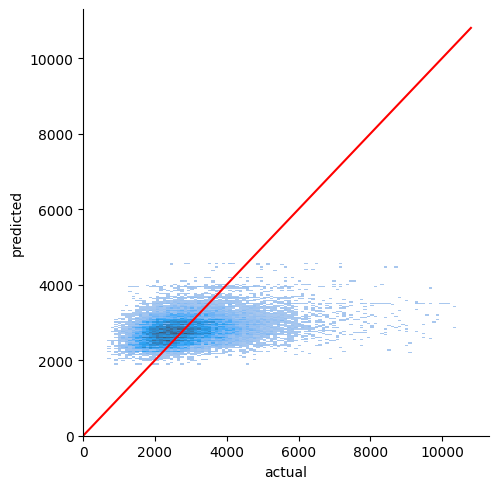

In [36]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

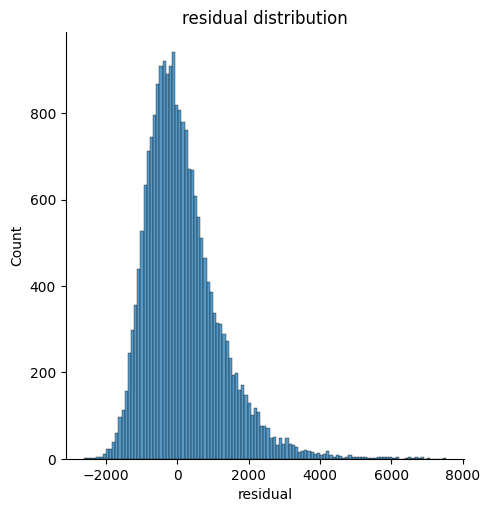

In [37]:
# Residual distribution
_ = sns.displot(df_pred["residual"])
_ = plt.title("residual distribution")

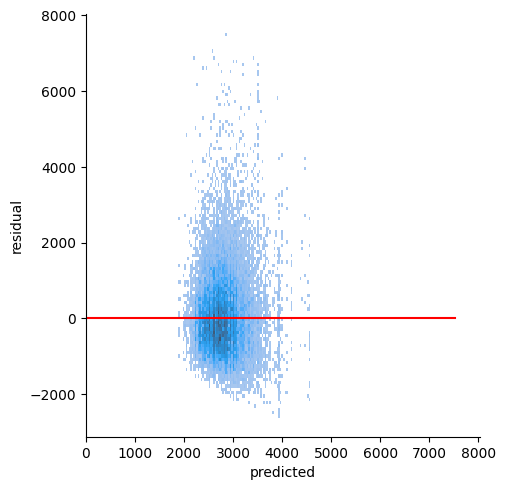

In [38]:
# Predicted vs residual
low_end = min(df_pred.residual)
max_resids = max(df_pred.residual)
_ = sns.displot(data = df_pred, x = "preds", y= "residual")
_ = plt.plot([0, max_resids], [0, 0], c = "red")
_ = plt.xlim(0, max_resids + 500)
_ = plt.ylim(low_end - 500, max_resids + 500)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

In [39]:
gp_model.summary()

Covariance parameters (random effects):
                Param.
Error_term 927015.2888
Group_1     10856.7142
Group_2    159334.0927


# Inference

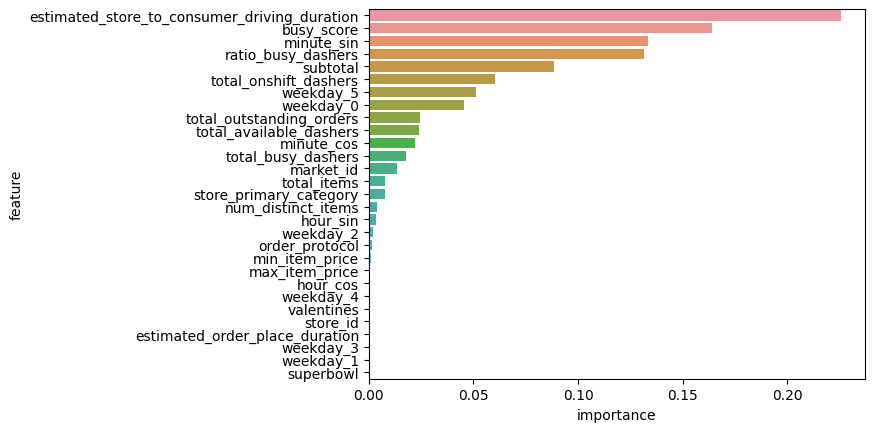

In [40]:
# Feature importances
importances = pd.DataFrame({"feature": X_test.columns.values, "importance": model.feature_importance(importance_type='gain')}).sort_values("importance", ascending = False)
_ = sns.barplot(data = importances, x = "importance", y = "feature", orient = "h")

In [41]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

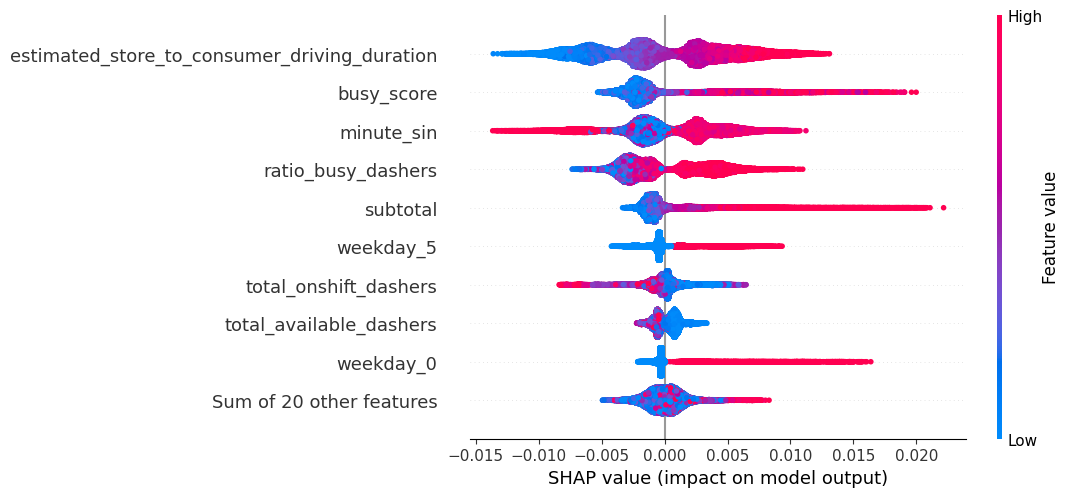

In [42]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

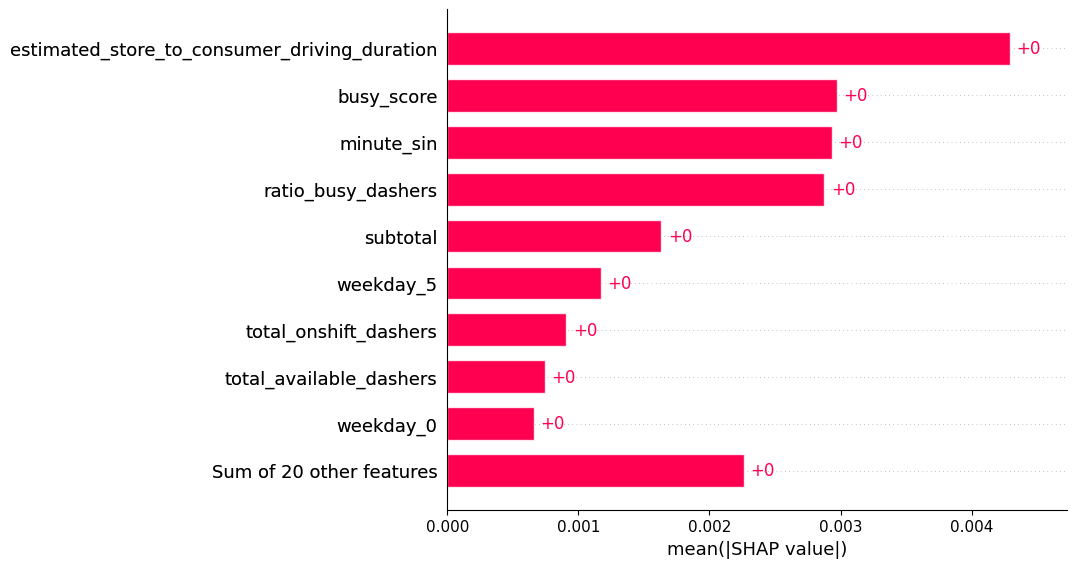

In [43]:
shap.plots.bar(shap_values)

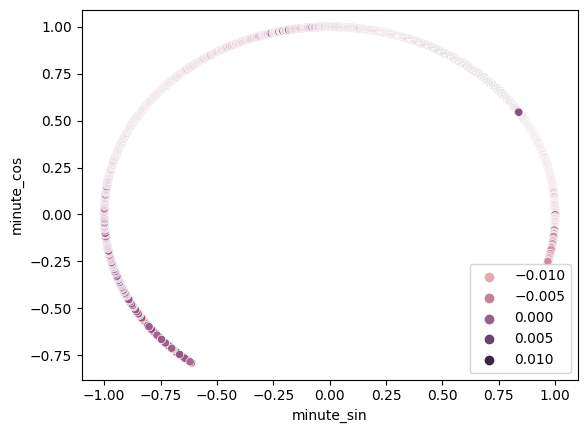

In [44]:
# EXPERIMENTAL: Plot cyclical minute feature's SHAP contributions
shap_sin = shap_values[:, "minute_sin"].values
shap_cos = shap_values[:, "minute_cos"].values
_ = sns.scatterplot(data = X_train, x = "minute_sin", y = "minute_cos", hue = (shap_sin + shap_cos))

- Bottom right: ~7AM

- Top: ~12AM

- Bottom left: ~14:30PM

# Findings
- Very little difference from GPBoost1, but the booster learned a bit more comparatively (27 vs 45 rounds).